In [86]:
import os
import sys

import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv
import math
pi = math.pi

# GREAT Cell HM test 2: permeability change in fracture

<img src="./Figures/ufz_HM2_model.png" alt="HM test2" width="400" height="400" />

### Set the loading conditions for BAGs (PEEs) and STRIP (DSSs)

Assign loading Conditions for BAG segments and apply on STRIP segments loading average of surrounding BAG segments.
<!-- ![Schematic view of Great Cell BC](./figures/greatcell_loading_schematic_xy.png#one-half "Schematic view of Great Cell BC.") -->

<img src="../3D/figures/greatcell_loading_schematic_xy.png" alt="Schematic view of Great Cell BC." style="width:400px;">


### Different loading conditions 


 HM2 loading (Unit: MPa):
   
|Maker| Angle PEE 1 to $\sigma_2$| **PEE 1**|**PEE 2**|**PEE 3**|**PEE 4**|**PEE 5**|**PEE 6**|**PEE 7**| **PEE 8**|
|-------------------      |---|----------|---------|---------|---------|----------|----------|----------|----------|
| B | 0 $^\circ$ |3.0| 4.3| 5.6| 7.0| 7.0| 5.6| 4.3| 3.0|
| C | 22.5 $^\circ$|4.3| 5.6| 7.0| 7.0| 5.6| 4.3| 3.0| 3.0|
| D | 45.0 $^\circ$|5.6| 7.0| 7.0| 5.6| 4.3| 3.0| 3.0| 4.3|
| E | 67.5 $^\circ$|7.0| 7.0| 5.6| 4.3| 3.0| 3.0| 4.3| 5.6|
| F | 90 $^\circ$|7.0| 5.6| 4.3| 3.0| 3.0| 4.3| 5.6| 7.0|


The top load is 12 MPa.

### Material parameters

We consider the samples as resin, greywacke and gneiss, respectively. The material parameters are given in the following table:  
|**Parameter**| **Unit** | **Resin** | **Greywacke**|**Gneiss**|
|-------------------|------|----------|---------|---------|
| Young's modulus | GPa|3.85| 26.85|57.1|
| Poisson's ratio | - | 0.4| 0.27| 0.19|
| Intrisinc permeability |$\text{m}^2$|  $10^{-21}$|2.85$\cdot 10^{-21}$|$10^{-19}$|


### Fracture properties

* initial apperture: $b_0 = 10^{-5}$ m.
* frature stiffness: two value sets are considered as
  1. high stiffness $k_{nn}=k_{tt}=100$ GPa/m,
  2. low stiffnesss $k_{nn}$ = 10 GPa/m, $k_{tt}=4$ GPa/m

### Results

The fracture mesh is extracted from the bulk mesh. The permeability and normal stress of the fracture at the center of the fracture mesh are fetched from the result VTU files and are plotted as follows: 

In [87]:
def get_fracture_k_and_s_at_the_center(root_directory, case_name = ''):
    # Define the directories
    directories = [root_directory + 'B',
                   root_directory + 'C',
                   root_directory + 'D',
                   root_directory + 'E',
                   root_directory + 'F']

    k_f_all = []
    k_sn_all = []

    #print("case_name: %s "% case_name)
    
    # Loop through the directories
    for directory in directories:
        # Find the pvd file
        #print("Find pvd in the directory %s" % directory)
        pvd_file = ''
        for file in os.listdir(directory):
            if file.endswith('.pvd'):                
                if case_name == '':
                    #print(file)
                    pvd_file = os.path.join(directory, file)
                    break
                elif case_name in file:
                    #print(file)
                    pvd_file = os.path.join(directory, file)
                    break
                             
        if pvd_file == '':
            sys.exit("No PVD file is found!")

        # Open the pvd file
        tree = ET.parse(pvd_file)
        root = tree.getroot()
    
        # Get the last DataSet tag
        last_dataset = root.findall('.//DataSet')[-1]
    
        # Get the 'file' attribute of the last DataSet tag
        file_attribute = last_dataset.attrib['file']
    
        #print(f"The 'file' attribute of the last DataSet tag in {pvd_file} is {file_attribute}.")
    
        file_name = os.path.join(directory, file_attribute)
        mesh = pv.read(file_name)
        target_mat_id = 0
        matIDs = mesh.cell_data["MaterialIDs"]
        submesh = mesh.extract_cells(np.where(matIDs == target_mat_id)[0])
        center_p_id = submesh.find_closest_point((0.02, 0.0, 0.11))
        k_f = submesh.point_data["fracture_permeability"][center_p_id]
        k_f_all.append(k_f)
        #print(f'The fracture permeability in the center is {k_f}')
        s_f = submesh.point_data["fracture_stress"][center_p_id]
        #print(f'The normal stress on the fracture is {s_f[2]}')
        k_sn_all.append(s_f[2])

    return np.array(k_f_all) * 1.e+11, -np.array(k_sn_all) * 1.e-6


In [88]:
angle = np.array([0, 22.5, 45, 67.5, 90]) * pi/180
mock_sn = 7 * (np.cos(angle)**2) + 3 * (np.sin(angle)**2)

In [89]:
def plot_figure(mock_sn, data_resin, data_greywacke, data_gneiss, ylabel, title, fig_file_name):
    labels = ['B', 'C', 'D', 'E', 'F']

    # Plotting
    plt.rcParams['figure.figsize'] = [5, 5]
    plt.plot(mock_sn, data_resin, marker='o', linestyle = 'dashed', label=r'Resin')
    plt.plot(mock_sn, data_greywacke, marker='*', linestyle = 'dashed', label=r'Greywacke')
    plt.plot(mock_sn, data_gneiss, marker='x', linestyle = 'dashed', label=r'Gneiss')
    for label, x, y in zip(labels, mock_sn, data_resin):
        plt.annotate(label, (x, y), textcoords="offset points", xytext=(10,-20), ha='center')

    #plt.title('Your Data Plot')
    plt.xlabel('Normal fracture stress from the far stress state [MPa]')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()

    plt.savefig(fig_file_name)
    plt.show()


In [90]:
root_output_directory = 'output_new_load/high_kn/'
k_resin, sn_resin = get_fracture_k_and_s_at_the_center(root_output_directory)
   
root_output_directory = 'output_new_load/low_kn/'
k_l_resin, sn_l_resin = get_fracture_k_and_s_at_the_center(root_output_directory)

root_output_directory_gg = 'output_greywacke_gn/high_kn/'
k_greywacke, sn_greywacke = get_fracture_k_and_s_at_the_center(root_output_directory_gg, 'Greywacke')
k_gneiss, sn_gneiss = get_fracture_k_and_s_at_the_center(root_output_directory_gg, 'Gneiss')
root_output_directory_gg = 'output_greywacke_gn/low_kn/'
k_l_greywacke, sn_l_greywacke = get_fracture_k_and_s_at_the_center(root_output_directory_gg, 'Greywacke')
k_l_gneiss, sn_l_gneiss = get_fracture_k_and_s_at_the_center(root_output_directory_gg, 'Gneiss')


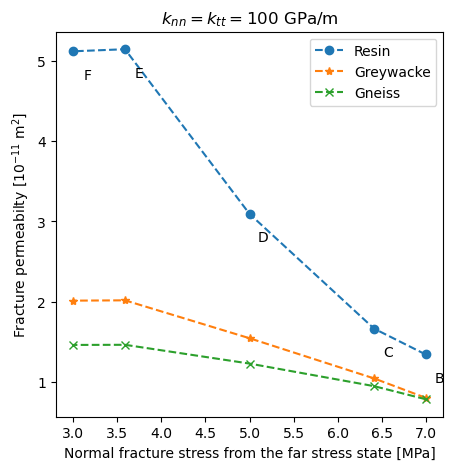

In [91]:
plot_figure(mock_sn, k_resin, k_greywacke, k_gneiss, r'Fracture permeabilty [$10^{-11}$ m$^2$]', r'$k_{nn}=k_{tt}=100$ GPa/m', 'k_f_high.png')

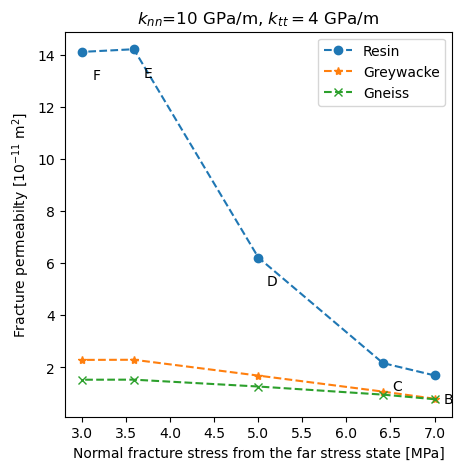

In [92]:
plot_figure(mock_sn, k_l_resin, k_l_greywacke, k_l_gneiss, r'Fracture permeabilty [$10^{-11}$ m$^2$]', r'$k_{nn}$=10 GPa/m, $k_{tt}=4$ GPa/m', 'k_f_low.png')

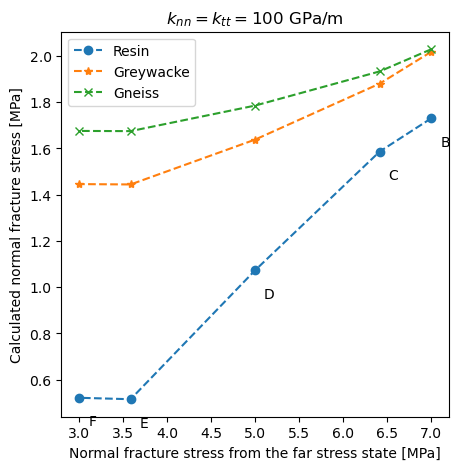

In [93]:
plot_figure(mock_sn, sn_resin, sn_greywacke, sn_gneiss, r'Calculated normal fracture stress [MPa]', r'$k_{nn}=k_{tt}=100$ GPa/m', 'sn_f_high.png')

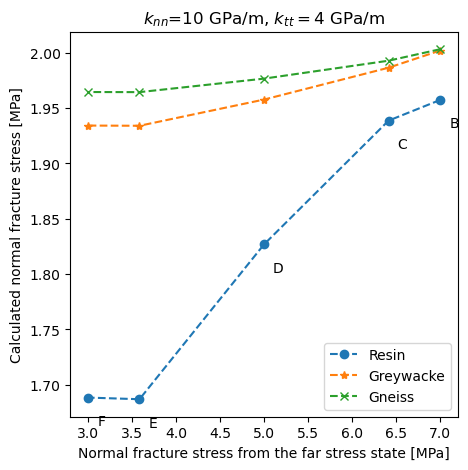

In [94]:
plot_figure(mock_sn, sn_l_resin, sn_l_greywacke, sn_l_gneiss, r'Calculated normal fracture stress [MPa]', r'$k_{nn}$=10 GPa/m, $k_{tt}=4$ GPa/m', 'sn_f_low.png')